<a href="https://colab.research.google.com/github/DimaVlas/CycleGAN-Emotion-Generation/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 

- Function to flatten data

In [0]:
class Flatten(nn.Module):
    def forward(self, _input):
        return _input.view(_input.size(0), -1)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

# Residual Block. Block has 2 convolution layers


In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_ch):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm1 = nn.BatchNorm2d(in_ch)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1, bias=False)
        self.norm2 = nn.BatchNorm2d(in_ch)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.relu(self.norm1(x))

        x = self.conv2(x)
        x = self.norm2(x)
        # x = torch.sigmoid(x)

        return residual + x

# Generator

In [0]:
class Generator(nn.Module):
    def __init__(self, in_ch=1, size_x=48, size_y=48):
        super(Generator, self).__init__()
       
        first_block = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, 64, (7, 7), stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]

        self.first_block = nn.Sequential(*first_block)
        
        # Downsample
        downsample = [
            nn.Conv2d(64, 128, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ]
        
        downsample += [
            nn.Conv2d(128, 256, (3, 3), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]
        
        self.downsample = nn.Sequential(*downsample)

        # Residual Blocks

        self.res_blocks = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Upsample
        upsample = [
            nn.ConvTranspose2d(256, 128, (3, 3), stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ]
        
        upsample += [
            nn.ConvTranspose2d(128, 64, (3, 3), stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        
        upsample += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 1, (7, 7), stride=1, padding=0),
            nn.Tanh()
        ]
        
        self.upsample = nn.Sequential(*upsample)


    def forward(self, x):
        x = self.first_block(x)
        x = self.downsample(x)
        x = self.res_blocks(x)
        x = self.upsample(x)
        return x



# Discrimnator 

In [0]:
class Discriminator(nn.Module):
    def __init__(self, in_ch=1, size_x=48, size_y=48):
        super(Discriminator, self).__init__()
               
        model = [
            nn.Conv2d(in_ch, 64, (4, 4), stride=2, padding=1),
            # torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            nn.BatchNorm2d(64),
            nn.ReLU(),
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2
        
        model += [
            nn.Conv2d(64, 128, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(128, 256, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(256, 512, (4, 4), stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        model += [
            nn.Conv2d(512, 1, (4, 4), stride=2, padding=1),
            nn.ReLU()
        ]
        
        size_x = size_x // 2
        size_y = size_y // 2

        if size_x > 1 or size_y > 1:
            model += [
                Flatten(),
                nn.Linear(size_x * size_y, 1),
                nn.ReLU()
            ]
        
        self.model = nn.Sequential(*model)    


    def forward(self, x):
        return self.model(x)

# Image Utils

In [0]:
class Data:
    def __init__(self, img, psnr=None, time=None, mean=None):
        self.img = img
        self.psnr = psnr
        self.time = time
        self.mean = mean


def matplot_plot_images_dict(data_dict):
    i, columns = 0, len(data_dict)
    scale = columns * 3  # you can play with it
    plt.figure(figsize=(scale, scale))
    for key, data in data_dict.items():
        i, ax = i + 1, plt.subplot(1, columns, i + 1)
        if data.img.ndim == 3:
            if data.img.shape[0] == 1:  # 3D gray image
                tmp_img = data.img[0, :, :]
            else:  # RGB
                tmp_img = np.transpose(data.img, (1, 2, 0))
        else:  # 2D gray image, no changes needed
            tmp_img = data.img
        plt.imshow(tmp_img, cmap='gray')
        ax.text(0.5, -0.3, key + (" psnr: %.2f" % (data.psnr) if data.psnr is not None else ""),
                size=14, ha="center", transform=ax.transAxes)
    plt.show()

# **Image Pool**

In [0]:
import random
import torch


class ImagePool():
    """This class implements an image buffer that stores previously generated images.
    This buffer enables us to update discriminators using a history of generated images
    rather than the ones produced by the latest generators.
    """

    def __init__(self, pool_size):
        """Initialize the ImagePool class
        Parameters:
            pool_size (int) -- the size of image buffer, if pool_size=0, no buffer will be created
        """
        self.pool_size = pool_size
        if self.pool_size > 0:  # create an empty pool
            self.num_imgs = 0
            self.images = []

    def query(self, images):
        """Return an image from the pool.
        Parameters:
            images: the latest generated images from the generator
        Returns images from the buffer.
        By 50/100, the buffer will return input images.
        By 50/100, the buffer will return images previously stored in the buffer,
        and insert the current images to the buffer.
        """
        if self.pool_size == 0:  # if the buffer size is 0, do nothing
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if self.num_imgs < self.pool_size:   # if the buffer is not full; keep inserting current images to the buffer
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:  # by 50% chance, the buffer will return a previously stored image, and insert the current image into the buffer
                    random_id = random.randint(0, self.pool_size - 1)  # randint is inclusive
                    tmp = self.images[random_id].clone()
                    self.images[random_id] = image
                    return_images.append(tmp)
                else:       # by another 50% chance, the buffer will return the current image
                    return_images.append(image)
        return_images = torch.cat(return_images, 0)   # collect all the images and return
        return return_images

# Read data utils

In [0]:
from __future__ import print_function, division

import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split

In [0]:
def get_params_by_dataset(dataset_name):
    if dataset_name == 'fer2013':
        size_x, size_y = 48, 48
        dataset = FER2013GetEmotion 
        in_ch = 1
        out = 7
    elif dataset_name == 'nova':
        size_x, size_y = 112, 92
        dataset = NovaDataset
        in_ch = 3
        out = 8
    else:
        size_x, size_y = 96, 96
        dataset = CKDataset
        in_ch = 1
        out = 8
    return dataset, in_ch, out, size_x, size_y

In [0]:
def get_train_transform(size_x, size_y, shift=12, rotate=0, scale_min=0.5, scale_max=1.5, shear=0, color_change=1):
    train_transform = transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            # transforms.ColorJitter(brightness=color_change, contrast=color_change, saturation=color_change),
            # transforms.RandomCrop((size_x, size_y), padding=shift),
            # transforms.RandomAffine(rotate, scale=[scale_min, scale_max], shear=shear),
            transforms.ToTensor(),
        ])  # dataset training transform
    return train_transform

In [0]:
class FER2013GetEmotion(Dataset):
        """FER2013 dataset."""
        
        def __init__(self, emotion_choosed=None, csv_file='fer2013.csv', root_dir='data', usage='Training', transform=None):
            """
            Args:
                csv_file (string): Path to the csv file.
                root_dir (string): Directory with all the images.
                usage is Training or PrivateTest or PublicTest
                transform (callable, optional): Optional transform to be applied
                    on a sample.
            """
            self.emotions_dic = {
                'Angry': 0, 'Disgust': 1, 'Fear': 2,
                'Happy': 3, 'Sad': 4, 'Surprise': 5,
                'Neutral': 6}
            if emotion_choosed is None:
                self.emotion = ('Angry', 'Disgust')
            
            self.emotion = emotion_choosed
            
            csv_file = '/content/drive/My Drive/Technion/Semester 12/GAN Project/fer2013.csv'# os.path.join(root_dir, csv_file)
            df = pd.read_csv(csv_file, delimiter=',', header=0)
        
            # Added groupBy
            grouped_df = df.groupby(['emotion'])
            
            grouped_emotion_A = grouped_df.get_group(self.emotions_dic[self.emotion[0]])
            grouped_emotion_B = grouped_df.get_group(self.emotions_dic[self.emotion[1]])
            
            
            self.emotion_A_cat = grouped_emotion_A.loc[grouped_emotion_A['Usage'] == usage].copy()
            self.emotion_B_cat = grouped_emotion_B.loc[grouped_emotion_B['Usage'] == usage].copy()
            
            diff = len(self.emotion_A_cat) - len(self.emotion_B_cat)
            amount_samples_lack =  abs(len(self.emotion_A_cat) - len(self.emotion_B_cat))
            
            if diff < 0:
              # If A < B: Take |A|/2 random samples from A:  2*|A-B|/|A| times
              batch_of_data = int(len(self.emotion_A_cat)/2)
              for i in range(1, int(2*amount_samples_lack/len(self.emotion_A_cat))):
                self.emotion_A_cat = self.emotion_A_cat.append(self.emotion_A_cat.sample(n=batch_of_data))
                
            if diff > 0:
              # If A > B: Take |B|/2 random samples from B:  2*|A-B|/|B| times
              batch_of_data = int(len(self.emotion_B_cat)/2)
              for i in range(1, int(2*amount_samples_lack/len(self.emotion_B_cat))):
                self.emotion_B_cat = self.emotion_B_cat.append(self.emotion_B_cat.sample(n=batch_of_data))
                
            self.transform = transform


        def __len__(self):
            return min(len(self.emotion_A_cat),len(self.emotion_B_cat))

        def __getitem__(self, idx):
            # TODO: random
            row_A = self.emotion_A_cat.iloc[idx]
            face_A = row_A['pixels']
            res_A = [int(i) for i in face_A.split(' ')]
            res_A = np.array(res_A, dtype=np.uint8)
            res_A = np.reshape(res_A, (48, 48))
            im_A = Image.fromarray(res_A, 'L')
            if self.transform:
                im_A = self.transform(im_A)
            
            row_B = self.emotion_B_cat.iloc[idx]
            face_B = row_B['pixels']
            res_B = [int(i) for i in face_B.split(' ')]
            res_B = np.array(res_B, dtype=np.uint8)
            res_B = np.reshape(res_B, (48, 48))
            im_B = Image.fromarray(res_B, 'L')
            if self.transform:
                im_B = self.transform(im_B)
            return {'A': im_A, 'B': im_B,
                    'Label_A': row_A['emotion'],  'Label_B': row_B['emotion']}  # image, label

# Train

In [0]:
if True:
    dtype = torch.cuda.FloatTensor
else:
    dtype = torch.FloatTensor

In [0]:
def torch_to_np(img_var):
    '''Converts an image in torch.Tensor format to np.array.
    From 1 x C x W x H [0..1] to  C x W x H [0..1]
    '''
    return img_var.detach().cpu().numpy()[0]


def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.   
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)  
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)
    return Image.fromarray(ar)

In [0]:
def train_runner(netG_A2B, netG_B2A, netD_A, netD_B, emotion_A='Happy', emotion_B='Sad',
                 out_folder='/content/drive/My Drive/Technion/Semester 12/GAN Project/models_colab/sad', lr_g=0.0002, lr_d=0.0001, n_epochs=100,
                 batchSize=4, dataset_class=None, load=False, image_pool_size=16):
    
    # Optimizers & LR schedulers
    optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                   lr=lr_g, betas=(0.5, 0.999))
    optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # folder of the nets:
    netG_A2B_folder = os.path.join(out_folder, 'netG_A2B.pth')
    netG_B2A_folder = os.path.join(out_folder, 'netG_B2A.pth')
    netD_A_folder = os.path.join(out_folder, 'netD_A.pth')
    netD_B_folder = os.path.join(out_folder, 'netD_B.pth')
    epoch_number_folder = os.path.join(out_folder, 'epoch.txt')
    optimizers_folder = os.path.join(out_folder, 'optimizer.pth')
            
    # load?
    epoch = 0
    if load:
        # Load state dicts
        if os.path.exists(optimizers_folder):
          optimizer_G.load_state_dict(torch.load(optimizers_folder)['optimizer_G_state_dict'])
          optimizer_D_A.load_state_dict(torch.load(optimizers_folder)['optimizer_D_A_state_dict'])
          optimizer_D_B.load_state_dict(torch.load(optimizers_folder)['optimizer_D_B_state_dict'])
          
        netG_A2B.load_state_dict(torch.load(netG_A2B_folder))
        netG_B2A.load_state_dict(torch.load(netG_B2A_folder))
        netD_A.load_state_dict(torch.load(netD_A_folder))
        netD_B.load_state_dict(torch.load(netD_B_folder))
        with open(epoch_number_folder) as file:
            epoch = int(file.read())
        n_epochs += epoch
        # read first line
        print("Loaded successfully")

    
    fake_A_pool = ImagePool(image_pool_size)  # create image buffer to store previously generated images
    fake_B_pool = ImagePool(image_pool_size)  # create image buffer to store previously generated images
    
    
    # Lossess
    criterion_GAN = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()

    # Read data
    # Inputs & targets memory allocation
    target_real = torch.ones([batchSize, 1, 1, 1]).type(dtype)
    target_fake = torch.zeros([batchSize, 1, 1, 1]).type(dtype)

    # Dataset loader
    dataset_name = 'fer2013'
    
    dataset, in_ch, out, size_x, size_y = get_params_by_dataset(dataset_name)   
    
    # Dtata loader with 3 - happy, 4 - sad datasets
    dataloader = DataLoader(dataset(emotion_choosed=(emotion_A, emotion_B), transform=get_train_transform(size_x, size_y)),
                            batch_size=batchSize, shuffle=True)


    # -------- Training -------- #
    for epoch in range(epoch, n_epochs):
        first = True
        # Dealing with the learning rate as per the epoch number
        if(epoch < 100) :
            lr_g = 0.0002
            lr_d = 0.0001
        else:
            lr_g = 0.0002 - 0.0002*(epoch-100)/100
            lr_d = 0.0001 - 0.0001*(epoch-100)/100

        print("------------------------  epoch {} --------------------------".format(epoch))
        for batch in dataloader:
           
            # Set model input
            # Get real items of domains A,B
            real_A = batch['A'].type(dtype)
            real_B = batch['B'].type(dtype)
            
            # ------ Generators A2B and B2A ------ #
            optimizer_G.zero_grad()

            # GAN loss
            fake_B = netG_A2B(real_A) #G_A(A)
            # GAN loss D_A(G_A(A))
            if (fake_B.shape[0] != 4):
                continue
            loss_GAN_A2B = criterion_GAN(netD_A(fake_B), target_real)

            fake_A = netG_B2A(real_B) #G_B(B)
            # GAN loss D_B(G_B(B))
            loss_GAN_B2A = criterion_GAN(netD_B(fake_A), target_real)

            # Cycle loss
            
            # Forward cycle loss || G_B(G_A(A)) - A||
            recovered_A = netG_B2A(fake_B) # G_B(G_A(A))
            loss_cycle_ABA = criterion_cycle(recovered_A, real_A) * 10.0

            # Backward cycle loss || G_A(G_B(B)) - B||
            recovered_B = netG_A2B(fake_A) # G_A(G_B(B))
            loss_cycle_BAB = criterion_cycle(recovered_B, real_B) * 10.0

            # Total loss
            loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            loss_G.backward()

            optimizer_G.step()
            ###################################
            
            # Print images
            if first == True:
              first = False
              images_dict = {
                  'Real ' + str(emotion_A): Data(torch_to_np(real_A)),
                  'Fake ' + str(emotion_B): Data(torch_to_np(fake_B)),
                  'Recovered ' + str(emotion_A): Data(torch_to_np(recovered_A)),
              }
              matplot_plot_images_dict(images_dict)

              images_dict = {
                  'Real ' + str(emotion_B): Data(torch_to_np(real_B)),
                  'Fake ' + str(emotion_A): Data(torch_to_np(fake_A)),
                  'Recovered ' + str(emotion_B): Data(torch_to_np(recovered_B)),
              }

              matplot_plot_images_dict(images_dict)
            
            ###################################

            # ------ Discriminator A ------ #
            optimizer_D_A.zero_grad()

            # Real_B loss 1
            loss_D_real = criterion_GAN(netD_A(real_B), target_real)
            
            # Fake_B loss 0
            fake_B = fake_B_pool.query(fake_B)
            loss_D_fake = criterion_GAN(netD_A(fake_B.detach()), target_fake)

            # Total loss
            loss_D_A = (loss_D_real + loss_D_fake) * (0.5)
            loss_D_A.backward()

            optimizer_D_A.step()
            ###################################

            # ------ Discriminator B ------ #
            optimizer_D_B.zero_grad()

            # Real_B loss 1
            loss_D_real = criterion_GAN(netD_B(real_A), target_real)
            
            # Fake loss
            fake_A = fake_A_pool.query(fake_A)
            loss_D_fake = criterion_GAN(netD_B(fake_A.detach()), target_fake)

            # Total loss
            loss_D_B = (loss_D_real + loss_D_fake) * (0.5)
            loss_D_B.backward()

            optimizer_D_B.step()
            ###################################
            
                
            print('\rloss_G: {0}, loss_G_GAN: {1}, loss_G_cycle: {2}, loss_D: {3}'.format(loss_G,
                                                                                        (loss_GAN_A2B + loss_GAN_B2A),
                                                                                        (loss_cycle_ABA + loss_cycle_BAB),
                                                                                        (loss_D_A + loss_D_B))
                 , end='')


        # Save models checkpoints
        
        torch.save({
            'optimizer_G_state_dict': optimizer_G.state_dict(),
            'optimizer_D_A_state_dict': optimizer_D_A.state_dict(),
            'optimizer_D_B_state_dict': optimizer_D_B.state_dict()
            }, optimizers_folder)
        torch.save(netG_A2B.state_dict(), netG_A2B_folder)
        torch.save(netG_B2A.state_dict(), netG_B2A_folder)
        torch.save(netD_A.state_dict(), netD_A_folder, )
        torch.save(netD_B.state_dict(), netD_B_folder)
        with open(epoch_number_folder, 'w+') as file:
            file.write(str(epoch + 1))
        print("\nSAVED\n")



STARTED TRAINING

Loaded successfully
------------------------  epoch 120 --------------------------


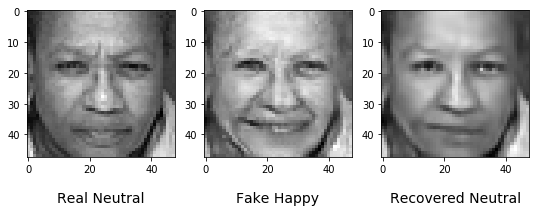

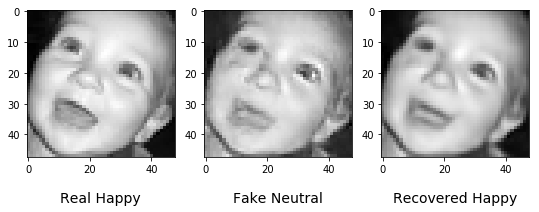

loss_G: 2.79878568649292, loss_G_GAN: 1.969170093536377, loss_G_cycle: 0.829615592956543, loss_D: 0.0216359980404377
SAVED

------------------------  epoch 121 --------------------------


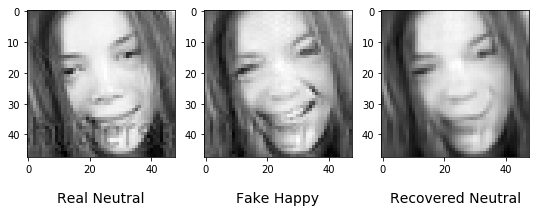

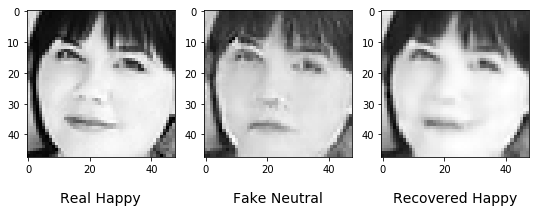

loss_G: 2.6769185066223145, loss_G_GAN: 1.9670960903167725, loss_G_cycle: 0.7098225355148315, loss_D: 0.02161211147904396
SAVED

------------------------  epoch 122 --------------------------


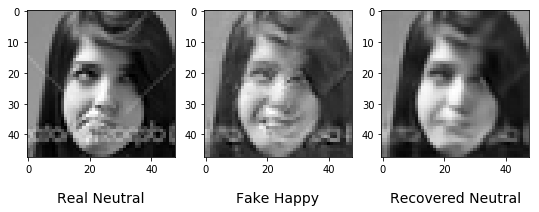

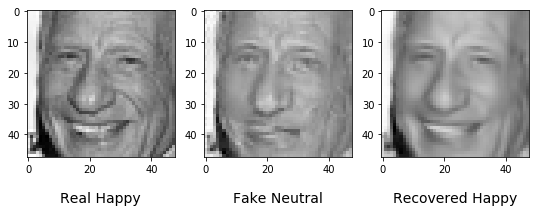

loss_G: 2.655211925506592, loss_G_GAN: 2.0, loss_G_cycle: 0.6552120447158813, loss_D: 0.004445686005055904
SAVED

------------------------  epoch 123 --------------------------


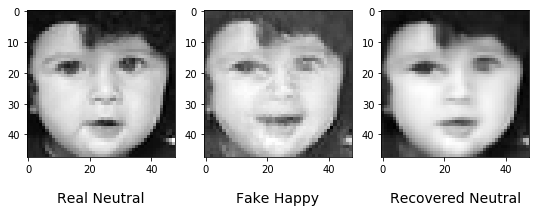

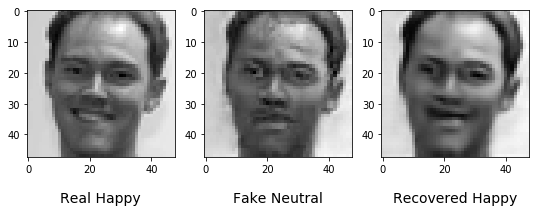

loss_G: 2.7558975219726562, loss_G_GAN: 2.0, loss_G_cycle: 0.7558976411819458, loss_D: 0.03362816199660301
SAVED

------------------------  epoch 124 --------------------------


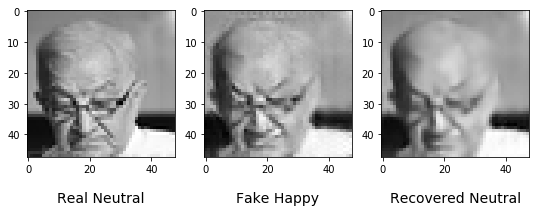

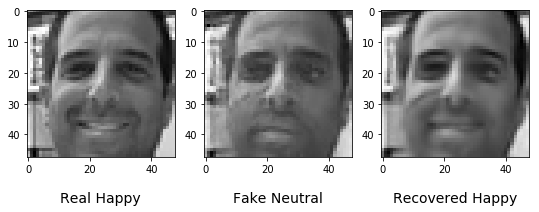

loss_G: 2.886122226715088, loss_G_GAN: 1.884204387664795, loss_G_cycle: 1.0019177198410034, loss_D: 0.028710968792438507
SAVED

------------------------  epoch 125 --------------------------


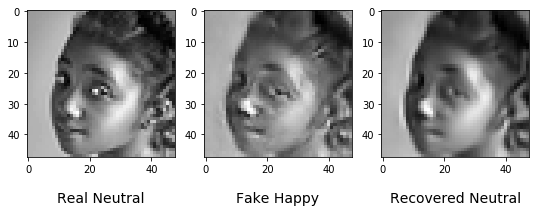

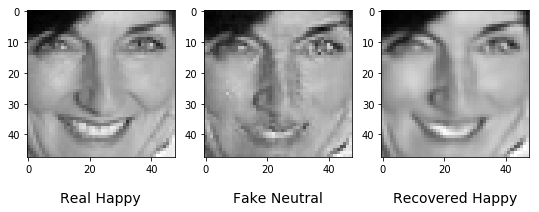

loss_G: 2.603071451187134, loss_G_GAN: 1.991515874862671, loss_G_cycle: 0.6115556359291077, loss_D: 0.005559995304793119
SAVED

------------------------  epoch 126 --------------------------


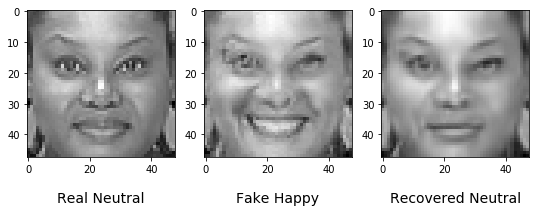

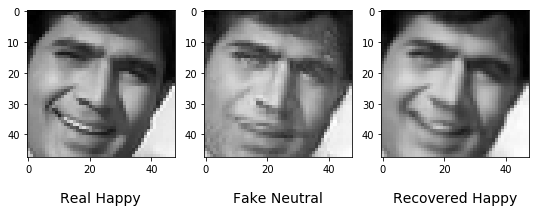

loss_G: 2.569624423980713, loss_G_GAN: 1.9301953315734863, loss_G_cycle: 0.6394291520118713, loss_D: 0.022469613701105118
SAVED

------------------------  epoch 127 --------------------------


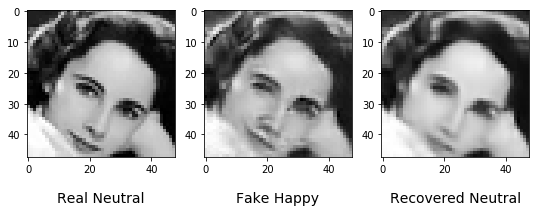

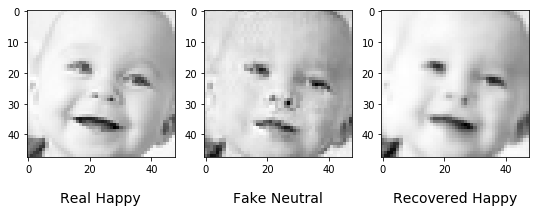

loss_G: 2.3914318084716797, loss_G_GAN: 1.757246494293213, loss_G_cycle: 0.6341853141784668, loss_D: 0.013228866271674633
SAVED

------------------------  epoch 128 --------------------------


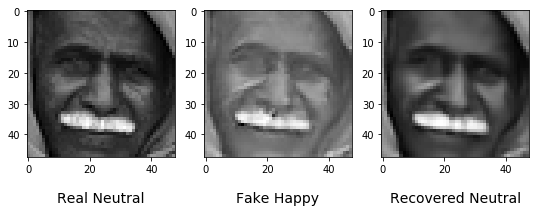

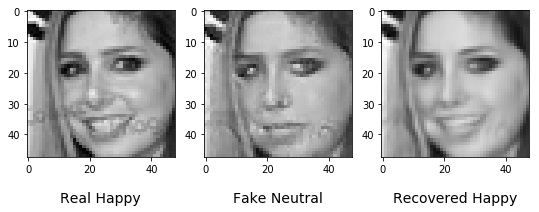

loss_G: 2.650434732437134, loss_G_GAN: 1.9559884071350098, loss_G_cycle: 0.6944462060928345, loss_D: 0.0072812167927622795
SAVED

------------------------  epoch 129 --------------------------


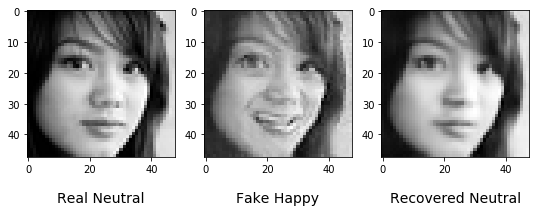

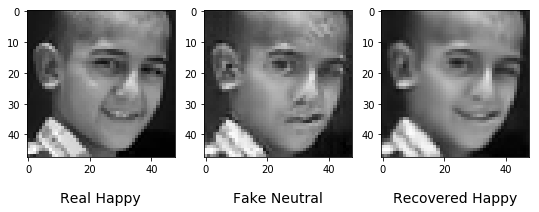

loss_G: 2.7315053939819336, loss_G_GAN: 1.996389389038086, loss_G_cycle: 0.7351159453392029, loss_D: 0.022649120539426804
SAVED

------------------------  epoch 130 --------------------------


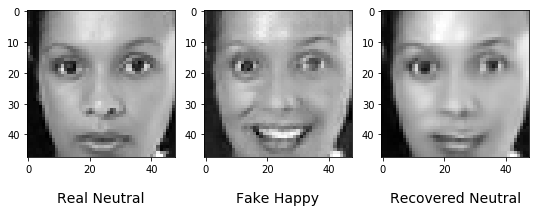

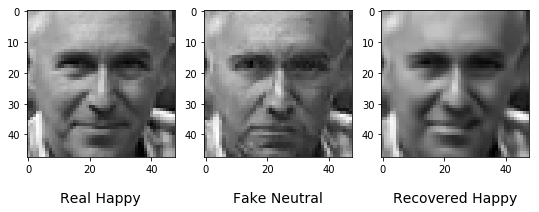

loss_G: 2.816453456878662, loss_G_GAN: 2.0, loss_G_cycle: 0.8164533972740173, loss_D: 0.022428248077630997
SAVED

------------------------  epoch 131 --------------------------


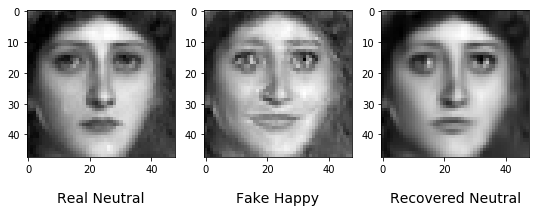

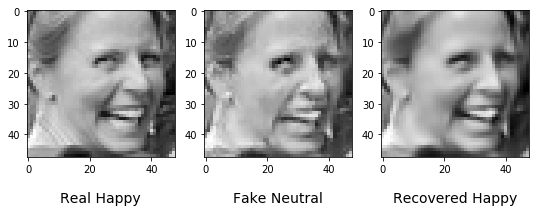

loss_G: 2.637352228164673, loss_G_GAN: 1.8517470359802246, loss_G_cycle: 0.7856053113937378, loss_D: 0.027946380898356438
SAVED

------------------------  epoch 132 --------------------------


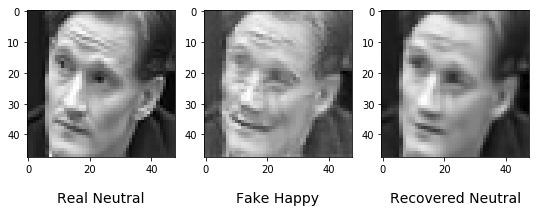

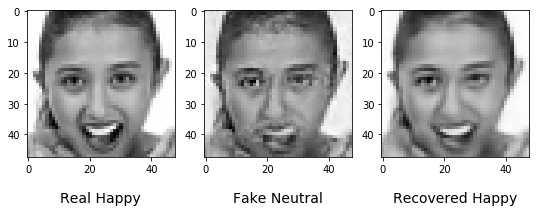

loss_G: 2.691676139831543, loss_G_GAN: 2.0, loss_G_cycle: 0.6916762590408325, loss_D: 0.016044562682509422
SAVED

------------------------  epoch 133 --------------------------


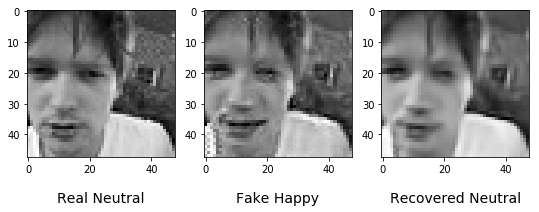

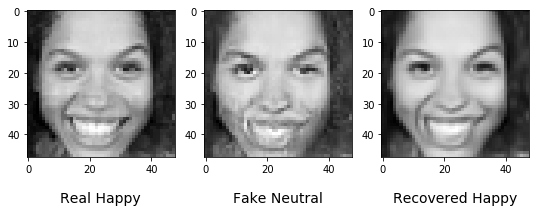

loss_G: 2.5145039558410645, loss_G_GAN: 1.8868355751037598, loss_G_cycle: 0.6276684999465942, loss_D: 0.02994466759264469
SAVED

------------------------  epoch 134 --------------------------


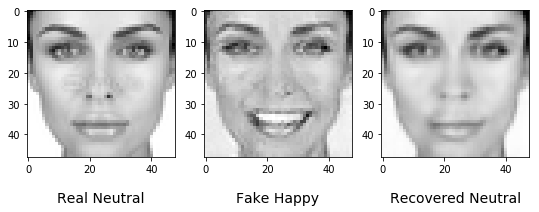

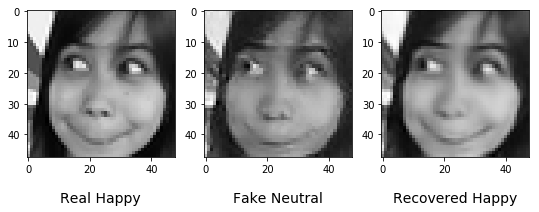

loss_G: 2.460695266723633, loss_G_GAN: 1.9494088888168335, loss_G_cycle: 0.5112863183021545, loss_D: 0.009325312450528145
SAVED

------------------------  epoch 135 --------------------------


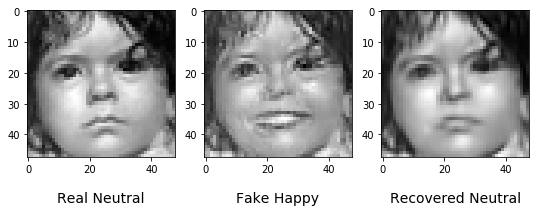

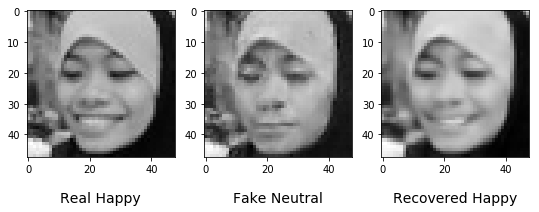

loss_G: 2.7522482872009277, loss_G_GAN: 1.9801005125045776, loss_G_cycle: 0.772147536277771, loss_D: 0.04964433237910271
SAVED

------------------------  epoch 136 --------------------------


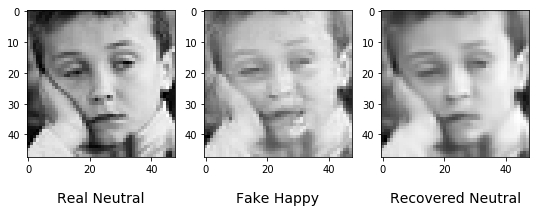

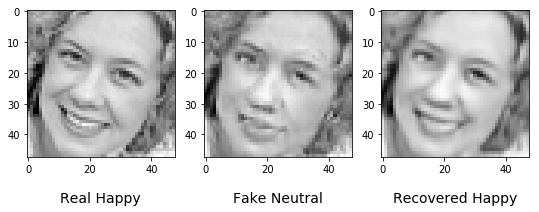

loss_G: 2.9500460624694824, loss_G_GAN: 1.9845179319381714, loss_G_cycle: 0.9655280113220215, loss_D: 0.012535985559225082
SAVED

------------------------  epoch 137 --------------------------


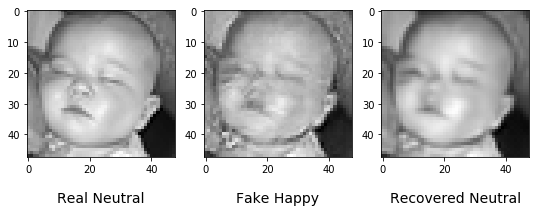

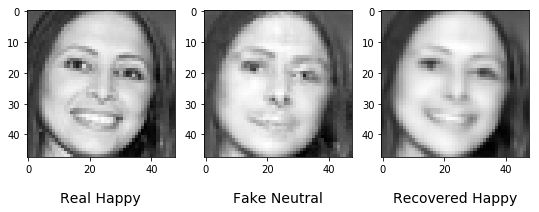

loss_G: 2.7046992778778076, loss_G_GAN: 2.0, loss_G_cycle: 0.7046992182731628, loss_D: 0.014170171692967415
SAVED

------------------------  epoch 138 --------------------------


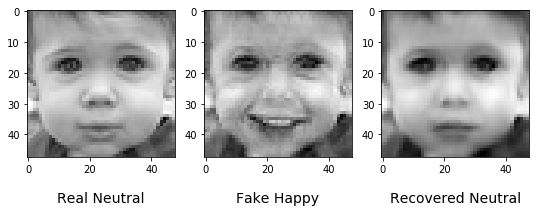

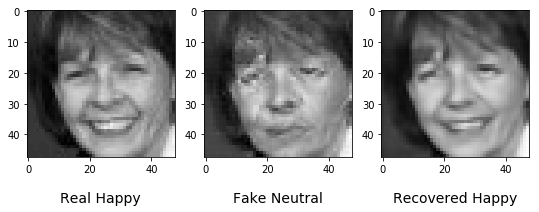

loss_G: 2.5486106872558594, loss_G_GAN: 2.0, loss_G_cycle: 0.5486108064651489, loss_D: 0.0067499857395887375
SAVED

------------------------  epoch 139 --------------------------


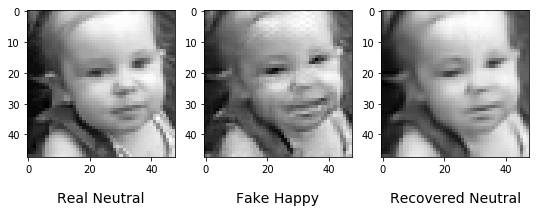

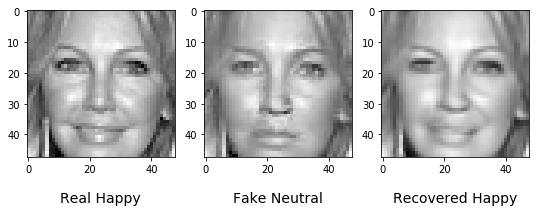

loss_G: 2.3289175033569336, loss_G_GAN: 1.7600650787353516, loss_G_cycle: 0.568852424621582, loss_D: 0.07335294783115387
SAVED

------------------------  epoch 140 --------------------------


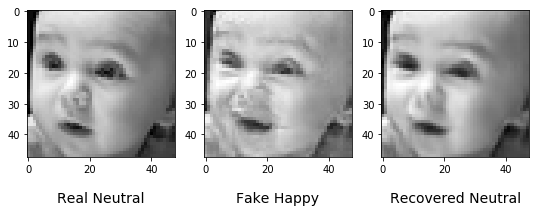

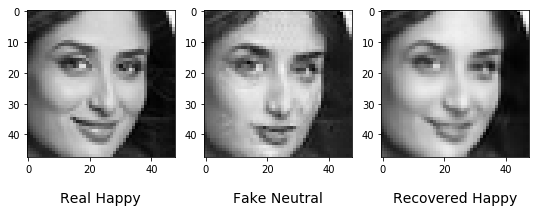

loss_G: 2.5158655643463135, loss_G_GAN: 1.9073741436004639, loss_G_cycle: 0.6084914207458496, loss_D: 0.02012389898300171
SAVED

------------------------  epoch 141 --------------------------


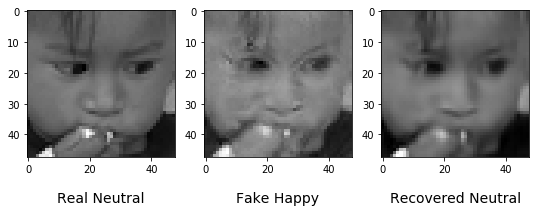

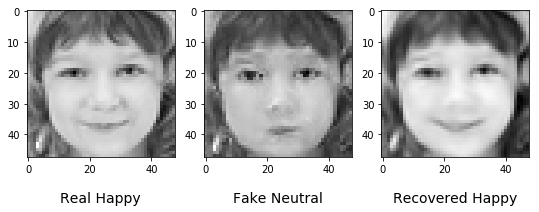

loss_G: 2.6204795837402344, loss_G_GAN: 2.0, loss_G_cycle: 0.6204795837402344, loss_D: 0.015150821767747402
SAVED

------------------------  epoch 142 --------------------------


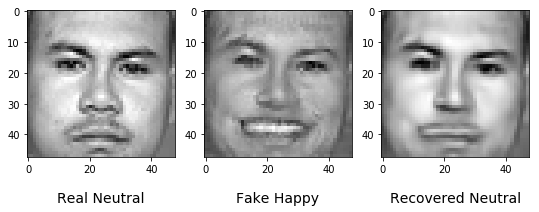

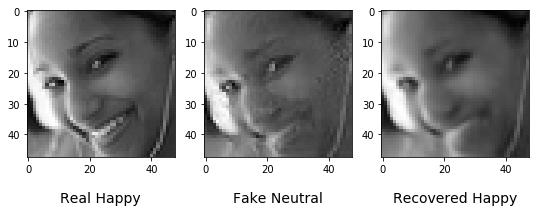

loss_G: 2.589728355407715, loss_G_GAN: 1.9945933818817139, loss_G_cycle: 0.5951349139213562, loss_D: 0.01795792207121849
SAVED

------------------------  epoch 143 --------------------------


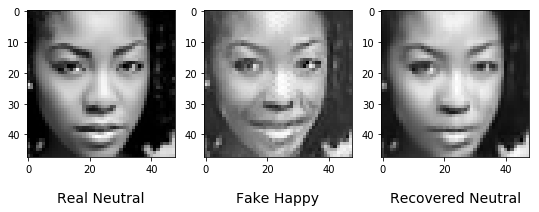

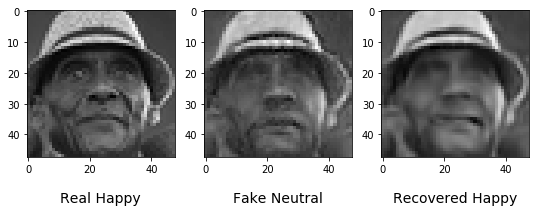

loss_G: 2.5069828033447266, loss_G_GAN: 1.9262667894363403, loss_G_cycle: 0.5807160139083862, loss_D: 0.007042964454740286
SAVED

------------------------  epoch 144 --------------------------


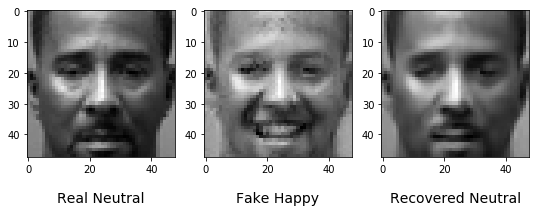

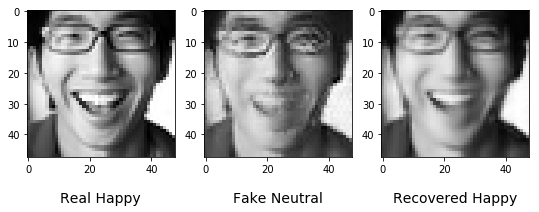

loss_G: 2.5527775287628174, loss_G_GAN: 1.9397013187408447, loss_G_cycle: 0.6130762696266174, loss_D: 0.0037002949975430965
SAVED

------------------------  epoch 145 --------------------------


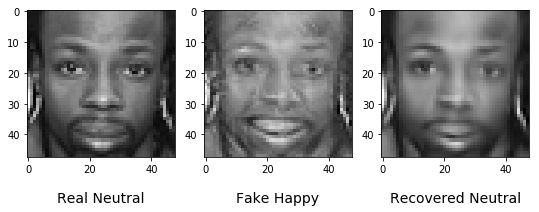

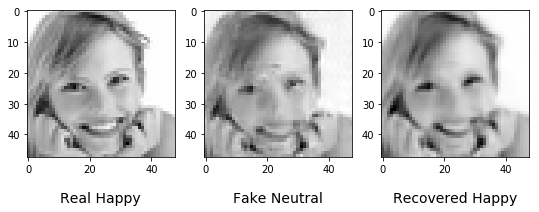

loss_G: 2.505046844482422, loss_G_GAN: 1.924116611480713, loss_G_cycle: 0.5809301137924194, loss_D: 0.011117067188024521
SAVED

------------------------  epoch 146 --------------------------


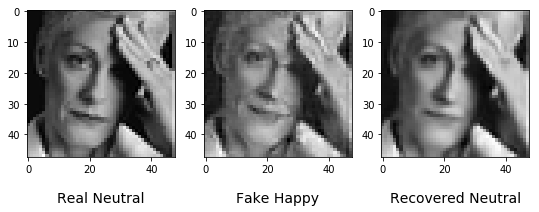

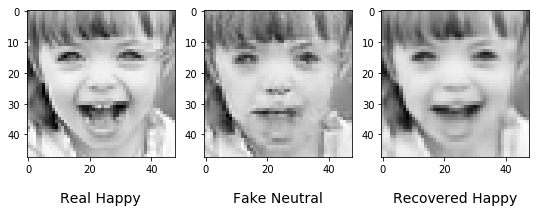

loss_G: 2.4773948192596436, loss_G_GAN: 2.0, loss_G_cycle: 0.47739478945732117, loss_D: 0.006295126862823963
SAVED

------------------------  epoch 147 --------------------------


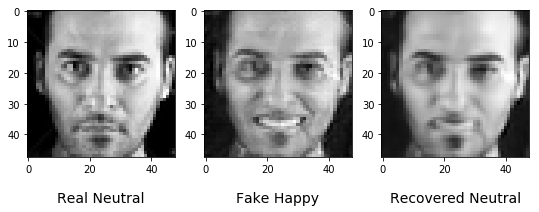

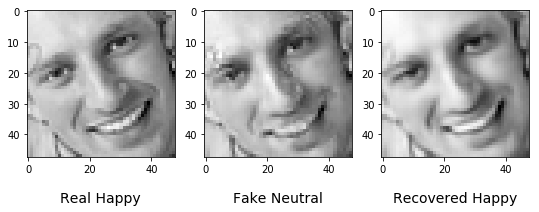

loss_G: 2.5964133739471436, loss_G_GAN: 2.0, loss_G_cycle: 0.5964133739471436, loss_D: 0.011797353625297546
SAVED

------------------------  epoch 148 --------------------------


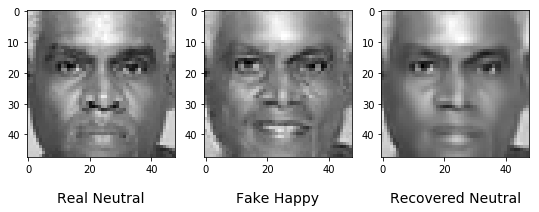

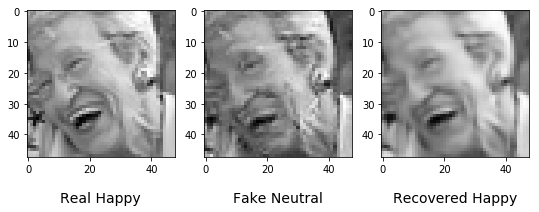

loss_G: 2.7395191192626953, loss_G_GAN: 2.0, loss_G_cycle: 0.7395191192626953, loss_D: 0.010455535724759102
SAVED

------------------------  epoch 149 --------------------------


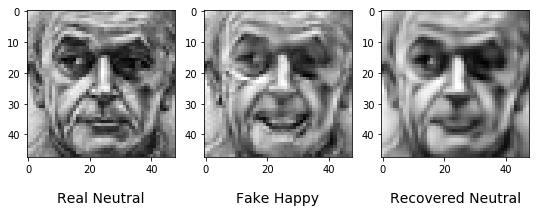

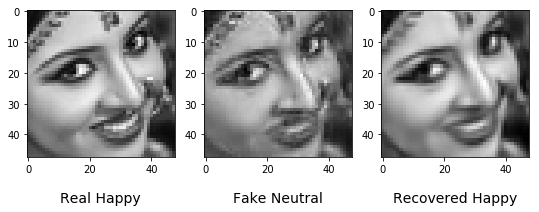

loss_G: 2.499401569366455, loss_G_GAN: 1.9488950967788696, loss_G_cycle: 0.5505064725875854, loss_D: 0.03771085664629936
SAVED

------------------------  epoch 150 --------------------------


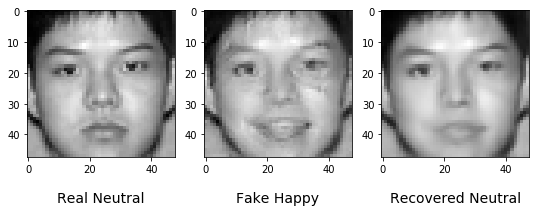

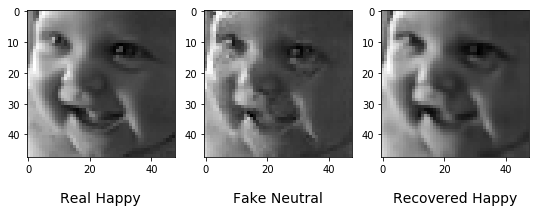

loss_G: 2.785147190093994, loss_G_GAN: 1.9960918426513672, loss_G_cycle: 0.7890552282333374, loss_D: 0.01863807439804077
SAVED

------------------------  epoch 151 --------------------------


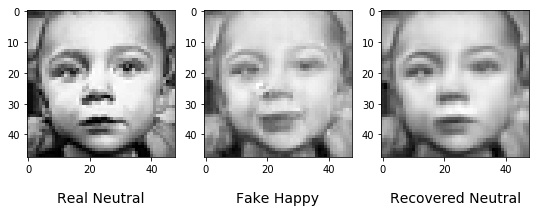

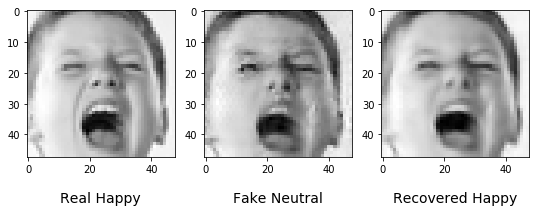

loss_G: 2.5383615493774414, loss_G_GAN: 1.9354664087295532, loss_G_cycle: 0.602895200252533, loss_D: 0.0102848494425416
SAVED

------------------------  epoch 152 --------------------------


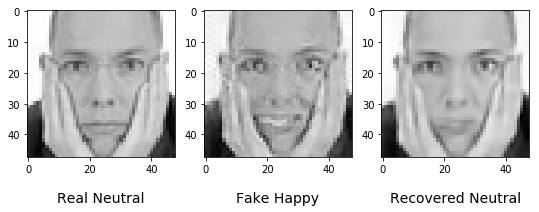

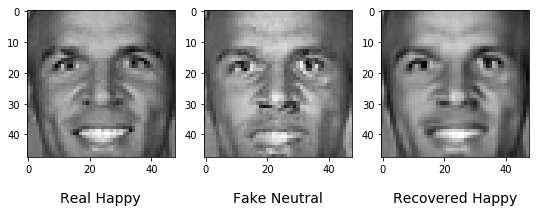

loss_G: 2.5194737911224365, loss_G_GAN: 2.0, loss_G_cycle: 0.5194738507270813, loss_D: 0.00923193246126175
SAVED

------------------------  epoch 153 --------------------------


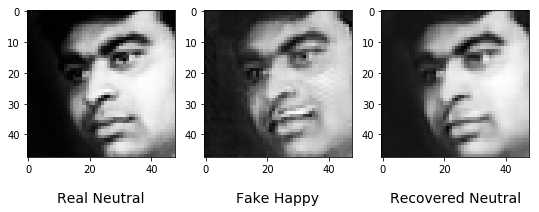

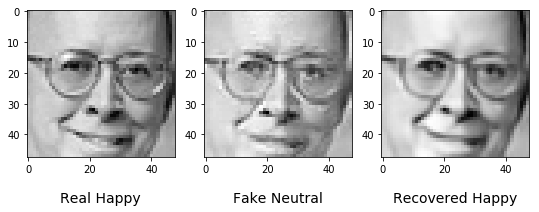

loss_G: 2.5407938957214355, loss_G_GAN: 2.0, loss_G_cycle: 0.5407937169075012, loss_D: 0.007586548570543528
SAVED

------------------------  epoch 154 --------------------------


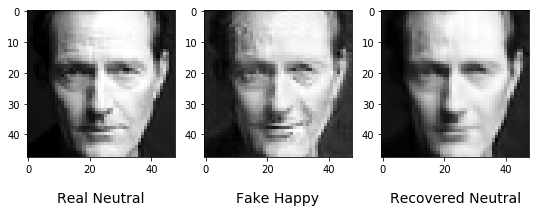

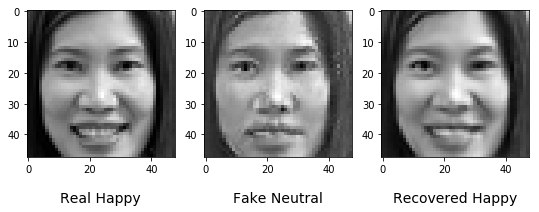

loss_G: 2.471467971801758, loss_G_GAN: 1.9062111377716064, loss_G_cycle: 0.5652569532394409, loss_D: 0.0234769769012928
SAVED

------------------------  epoch 155 --------------------------


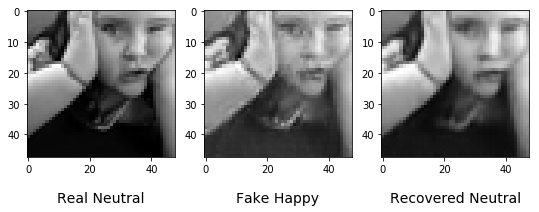

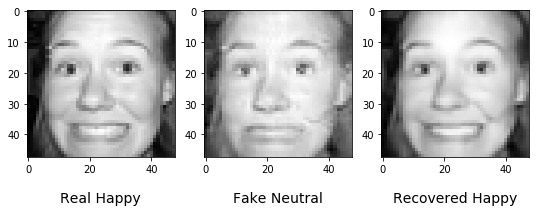

loss_G: 2.8292527198791504, loss_G_GAN: 1.9742016792297363, loss_G_cycle: 0.8550509214401245, loss_D: 0.027638178318738937
SAVED

------------------------  epoch 156 --------------------------


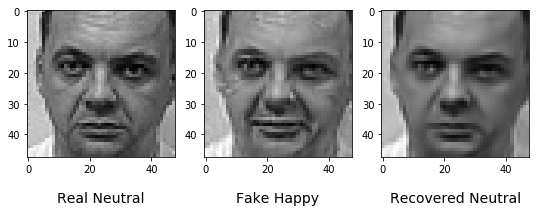

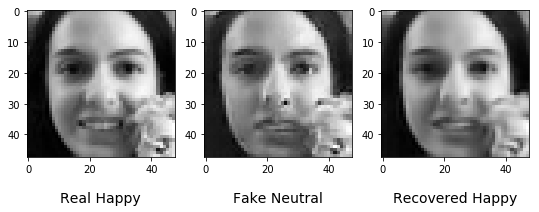

loss_G: 2.624746084213257, loss_G_GAN: 2.0, loss_G_cycle: 0.6247462034225464, loss_D: 0.01357986219227314
SAVED

------------------------  epoch 157 --------------------------


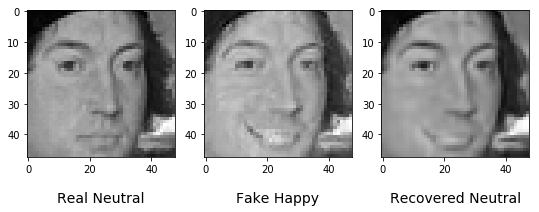

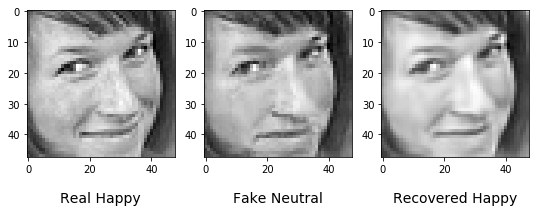

loss_G: 2.4548234939575195, loss_G_GAN: 2.0, loss_G_cycle: 0.45482349395751953, loss_D: 0.026706118136644363
SAVED

------------------------  epoch 158 --------------------------


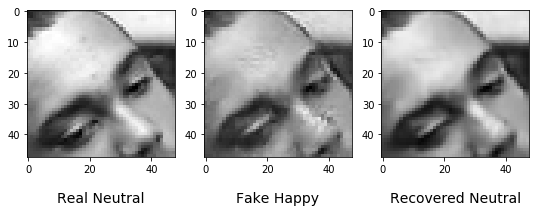

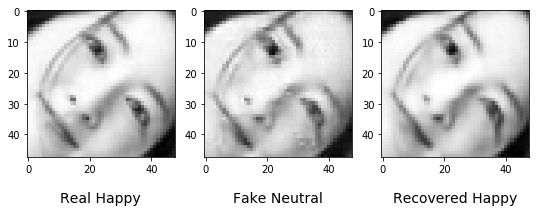

loss_G: 2.5413947105407715, loss_G_GAN: 2.0, loss_G_cycle: 0.5413947105407715, loss_D: 0.012728292495012283
SAVED

------------------------  epoch 159 --------------------------


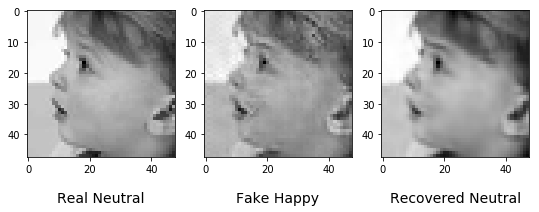

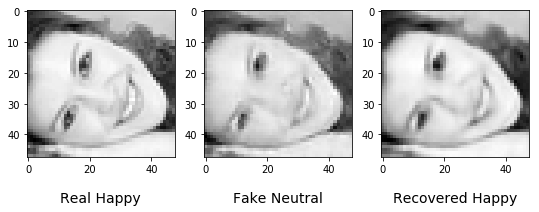

loss_G: 2.607304096221924, loss_G_GAN: 2.0, loss_G_cycle: 0.6073041558265686, loss_D: 0.00542667368426919
SAVED

------------------------  epoch 160 --------------------------


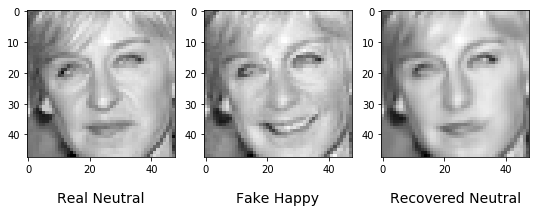

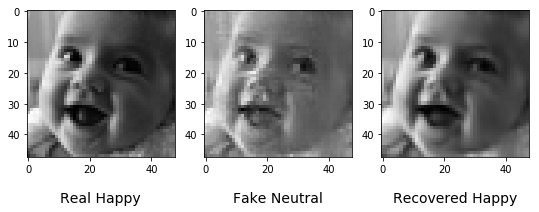

loss_G: 2.5947089195251465, loss_G_GAN: 2.0, loss_G_cycle: 0.5947089195251465, loss_D: 0.010645324364304543
SAVED

------------------------  epoch 161 --------------------------


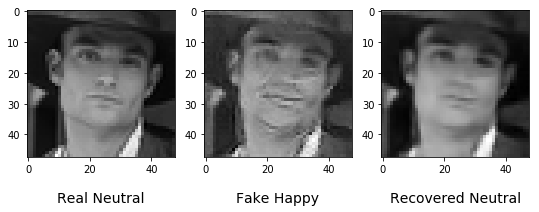

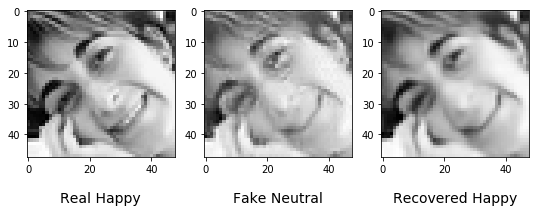

loss_G: 2.6069202423095703, loss_G_GAN: 2.0, loss_G_cycle: 0.606920063495636, loss_D: 0.012067961506545544
SAVED

------------------------  epoch 162 --------------------------


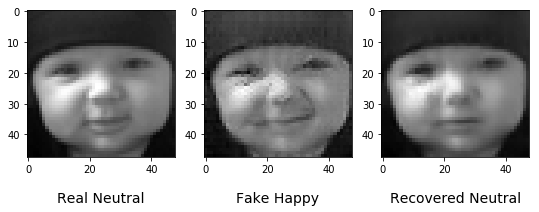

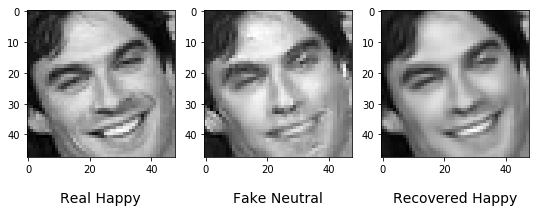

loss_G: 2.3745970726013184, loss_G_GAN: 1.9202443361282349, loss_G_cycle: 0.4543527364730835, loss_D: 0.014208248816430569
SAVED

------------------------  epoch 163 --------------------------


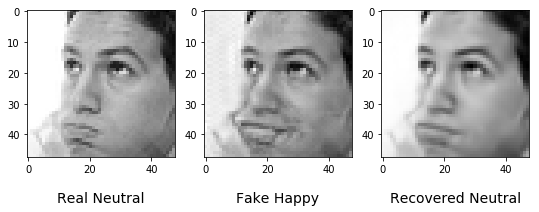

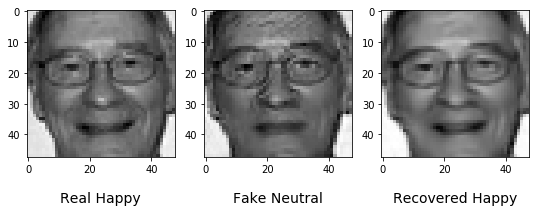

loss_G: 2.560969829559326, loss_G_GAN: 1.939084768295288, loss_G_cycle: 0.6218852400779724, loss_D: 0.010797413066029549
SAVED

------------------------  epoch 164 --------------------------


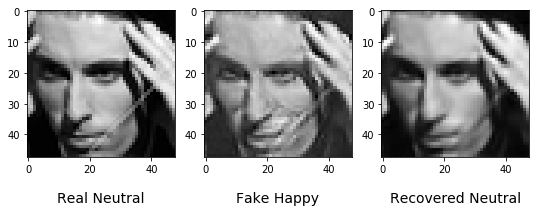

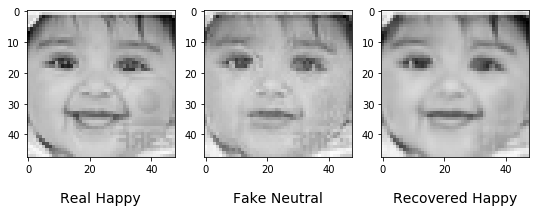

loss_G: 2.544090986251831, loss_G_GAN: 2.0, loss_G_cycle: 0.5440908670425415, loss_D: 0.00952991284430027
SAVED

------------------------  epoch 165 --------------------------


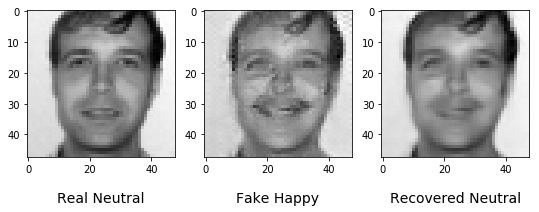

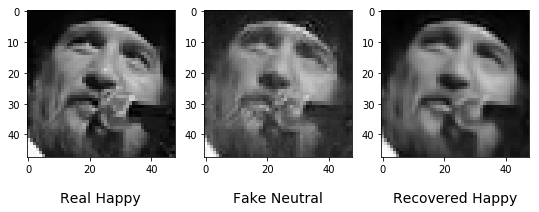

loss_G: 2.2544400691986084, loss_G_GAN: 1.8073911666870117, loss_G_cycle: 0.4470489025115967, loss_D: 0.017996639013290405
SAVED

------------------------  epoch 166 --------------------------


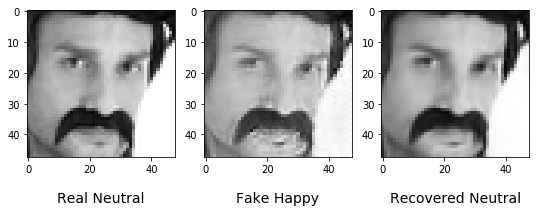

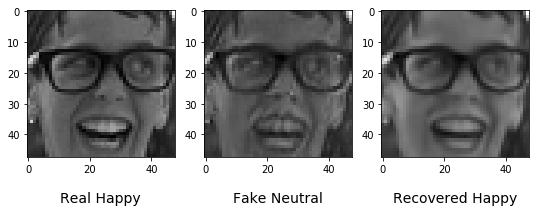

loss_G: 2.498462200164795, loss_G_GAN: 2.0, loss_G_cycle: 0.4984622299671173, loss_D: 0.031037503853440285
SAVED

------------------------  epoch 167 --------------------------


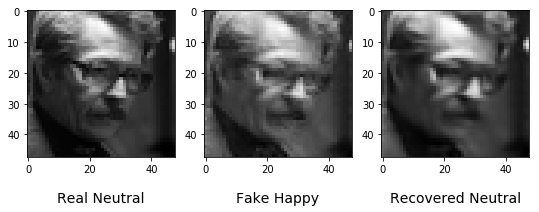

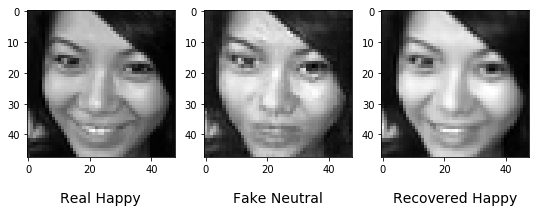

loss_G: 2.5207691192626953, loss_G_GAN: 1.8515701293945312, loss_G_cycle: 0.6691990494728088, loss_D: 0.01556346844881773
SAVED

------------------------  epoch 168 --------------------------


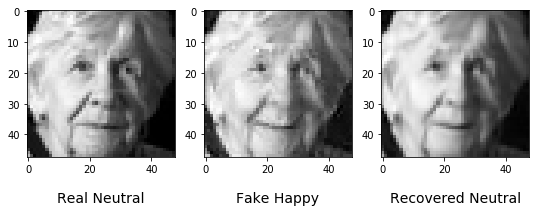

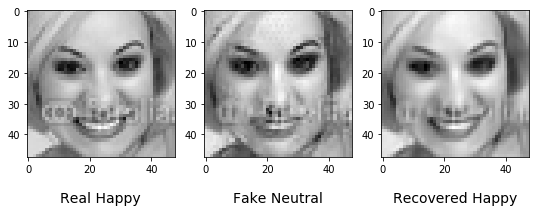

loss_G: 2.487942695617676, loss_G_GAN: 1.9319097995758057, loss_G_cycle: 0.5560328960418701, loss_D: 0.017919519916176796
SAVED

------------------------  epoch 169 --------------------------


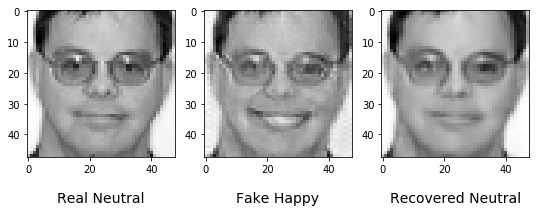

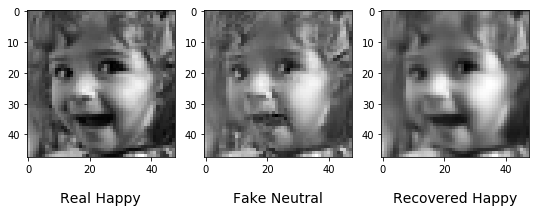

loss_G: 2.7270569801330566, loss_G_GAN: 1.9856455326080322, loss_G_cycle: 0.741411566734314, loss_D: 0.010990041308104992
SAVED

------------------------  epoch 170 --------------------------


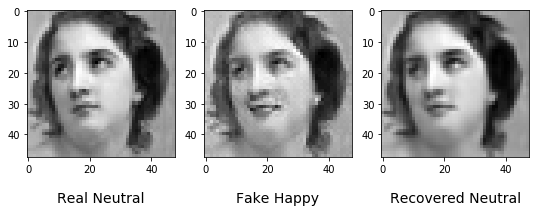

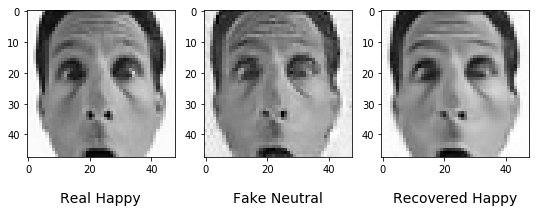

loss_G: 2.4546091556549072, loss_G_GAN: 2.0, loss_G_cycle: 0.45460909605026245, loss_D: 0.014478319324553013
SAVED

------------------------  epoch 171 --------------------------


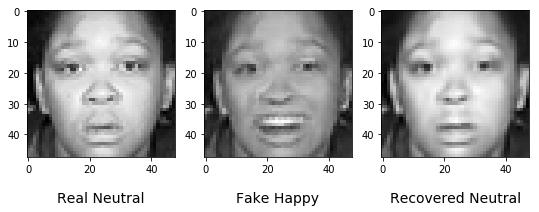

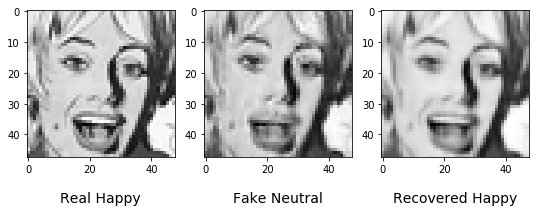

loss_G: 2.3478176593780518, loss_G_GAN: 1.7660536766052246, loss_G_cycle: 0.5817639231681824, loss_D: 0.010306545533239841
SAVED

------------------------  epoch 172 --------------------------


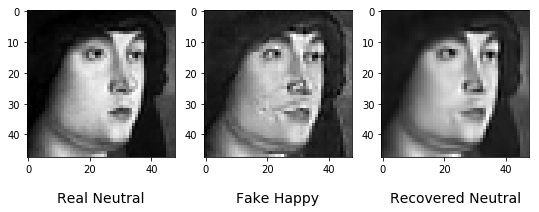

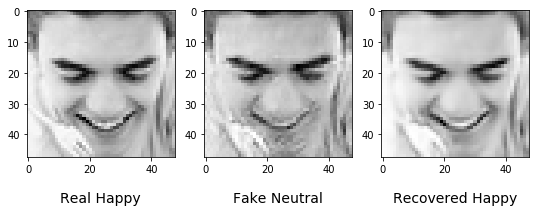

loss_G: 2.5378775596618652, loss_G_GAN: 2.0, loss_G_cycle: 0.5378775596618652, loss_D: 0.006009268574416637
SAVED

------------------------  epoch 173 --------------------------


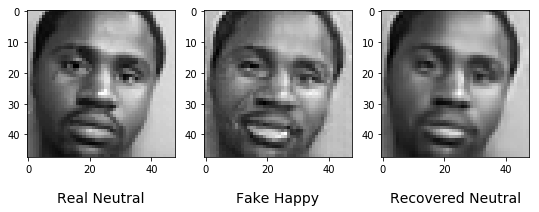

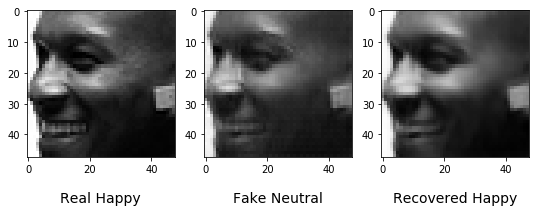

loss_G: 2.5749764442443848, loss_G_GAN: 1.9926481246948242, loss_G_cycle: 0.5823283195495605, loss_D: 0.02081070840358734
SAVED

------------------------  epoch 174 --------------------------


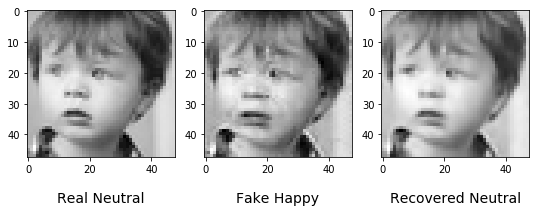

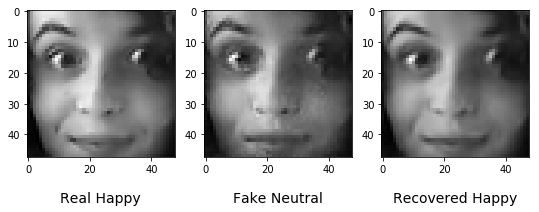

loss_G: 2.302311420440674, loss_G_GAN: 1.8659523725509644, loss_G_cycle: 0.4363591969013214, loss_D: 0.015467270277440548
SAVED

------------------------  epoch 175 --------------------------


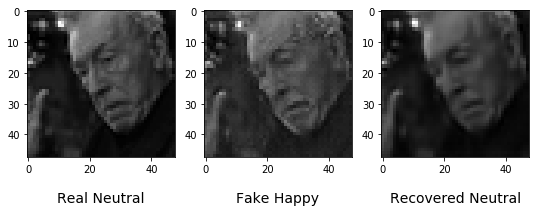

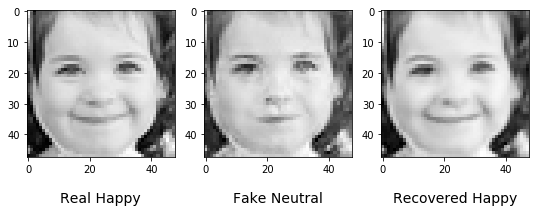

loss_G: 2.394937038421631, loss_G_GAN: 1.8680124282836914, loss_G_cycle: 0.5269245505332947, loss_D: 0.0059971921145915985
SAVED

------------------------  epoch 176 --------------------------


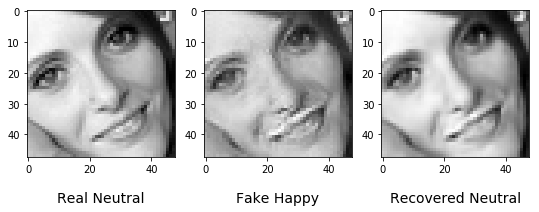

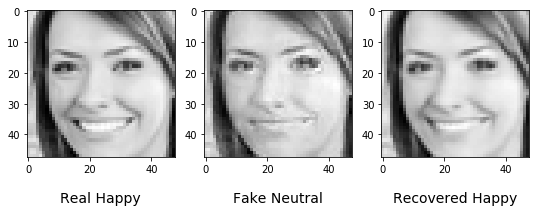

loss_G: 2.4544031620025635, loss_G_GAN: 2.0, loss_G_cycle: 0.45440298318862915, loss_D: 0.012944933958351612
SAVED

------------------------  epoch 177 --------------------------


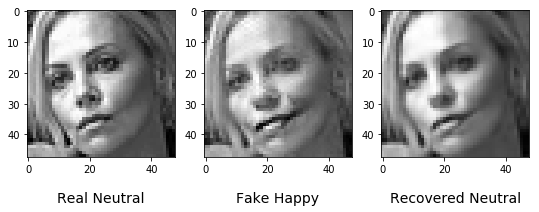

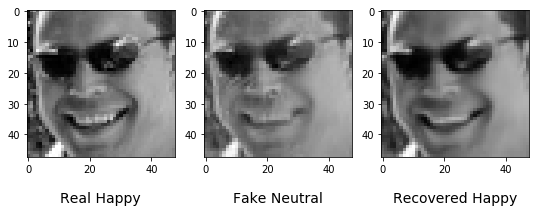

loss_G: 2.52079176902771, loss_G_GAN: 2.0, loss_G_cycle: 0.5207918286323547, loss_D: 0.00446364376693964
SAVED

------------------------  epoch 178 --------------------------


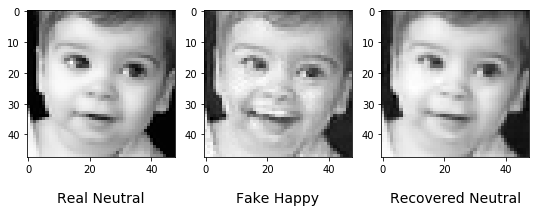

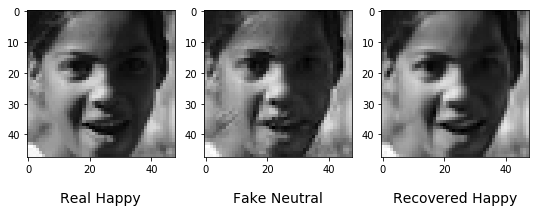

loss_G: 2.312689781188965, loss_G_GAN: 1.779958963394165, loss_G_cycle: 0.5327309370040894, loss_D: 0.017486775293946266
SAVED

------------------------  epoch 179 --------------------------


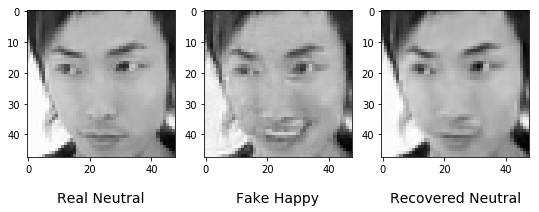

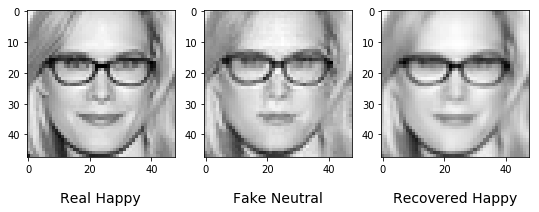

loss_G: 2.4465160369873047, loss_G_GAN: 1.9589030742645264, loss_G_cycle: 0.48761287331581116, loss_D: 0.004893145523965359
SAVED

------------------------  epoch 180 --------------------------


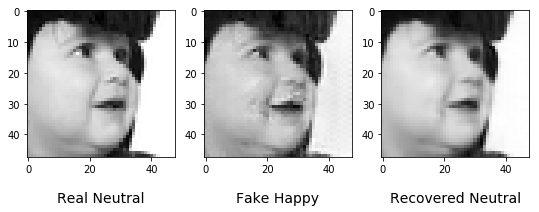

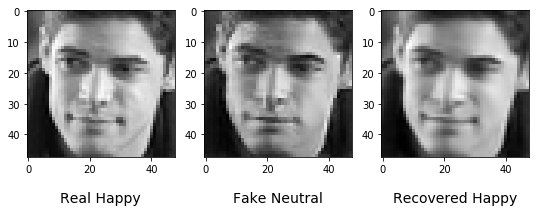

loss_G: 2.3826661109924316, loss_G_GAN: 1.9524732828140259, loss_G_cycle: 0.43019282817840576, loss_D: 0.006276585161685944
SAVED

------------------------  epoch 181 --------------------------


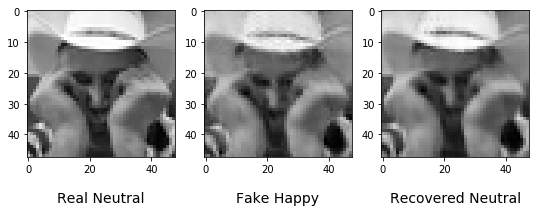

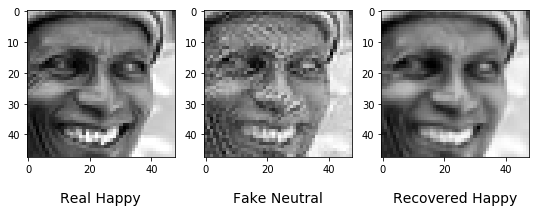

loss_G: 2.4171500205993652, loss_G_GAN: 2.0, loss_G_cycle: 0.41715002059936523, loss_D: 0.015127908438444138
SAVED

------------------------  epoch 182 --------------------------


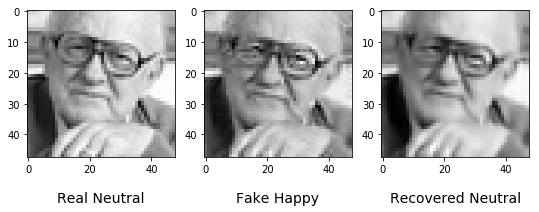

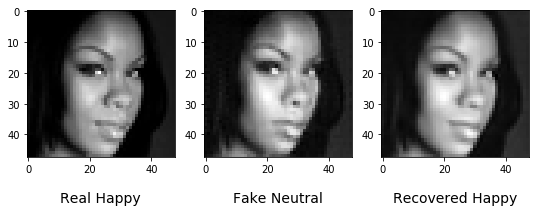

loss_G: 2.4550583362579346, loss_G_GAN: 1.9498041868209839, loss_G_cycle: 0.5052540898323059, loss_D: 0.006373968906700611
SAVED

------------------------  epoch 183 --------------------------


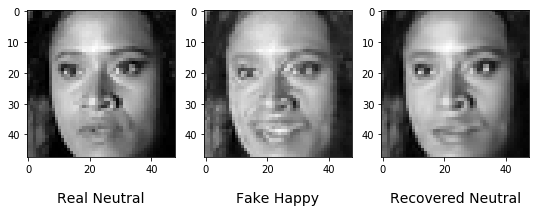

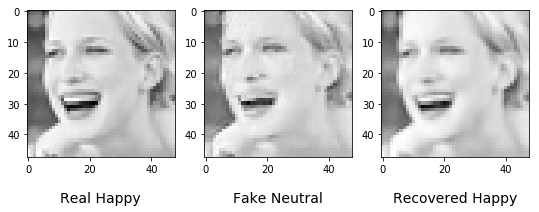

loss_G: 2.5104870796203613, loss_G_GAN: 2.0, loss_G_cycle: 0.5104871988296509, loss_D: 0.0079704150557518
SAVED

------------------------  epoch 184 --------------------------


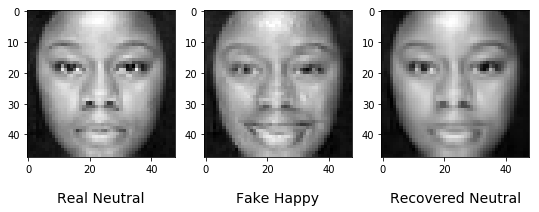

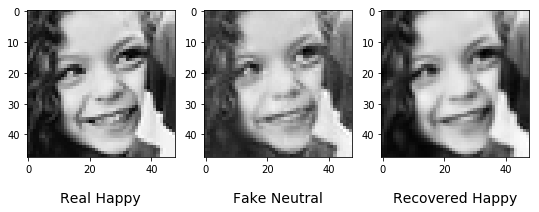

loss_G: 2.6513686180114746, loss_G_GAN: 1.9253751039505005, loss_G_cycle: 0.7259935140609741, loss_D: 0.00504673644900322
SAVED

------------------------  epoch 185 --------------------------


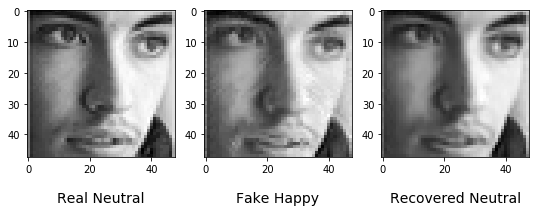

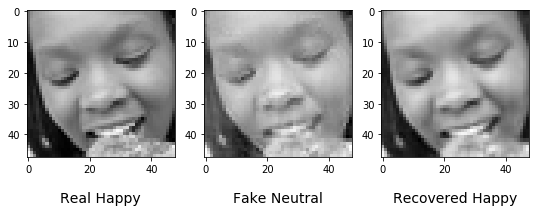

loss_G: 2.2450003623962402, loss_G_GAN: 1.7744321823120117, loss_G_cycle: 0.4705682694911957, loss_D: 0.006802481133490801
SAVED

------------------------  epoch 186 --------------------------


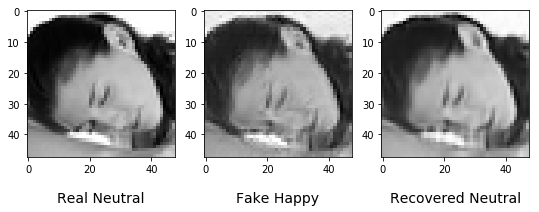

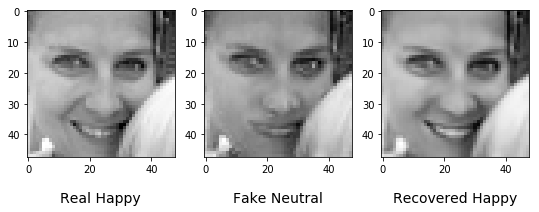

loss_G: 2.4850168228149414, loss_G_GAN: 1.9713573455810547, loss_G_cycle: 0.5136592984199524, loss_D: 0.008198561146855354
SAVED

------------------------  epoch 187 --------------------------


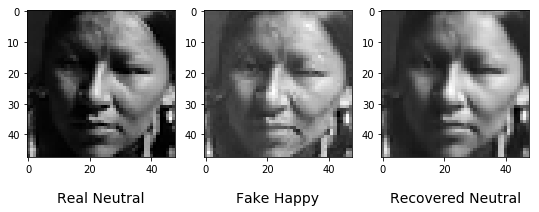

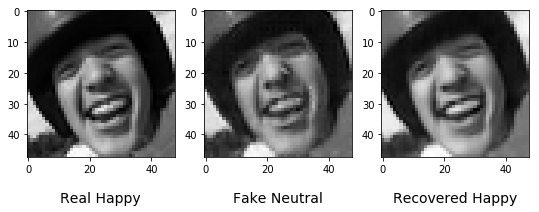

loss_G: 2.5771191120147705, loss_G_GAN: 1.875051498413086, loss_G_cycle: 0.702067494392395, loss_D: 0.013253003358840942
SAVED

------------------------  epoch 188 --------------------------


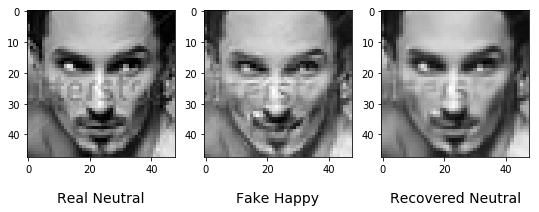

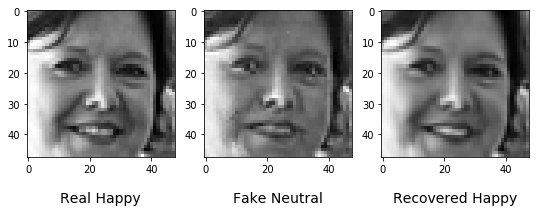

loss_G: 2.401569128036499, loss_G_GAN: 2.0, loss_G_cycle: 0.4015689492225647, loss_D: 0.0018549342639744282
SAVED

------------------------  epoch 189 --------------------------


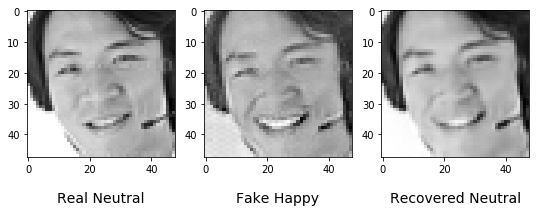

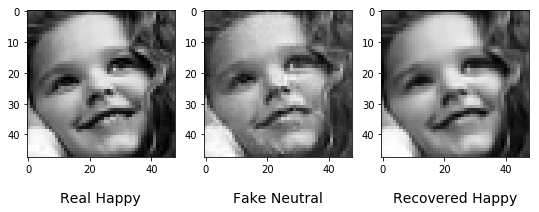

loss_G: 2.4273769855499268, loss_G_GAN: 1.9069206714630127, loss_G_cycle: 0.5204563140869141, loss_D: 0.008650165051221848
SAVED

------------------------  epoch 190 --------------------------


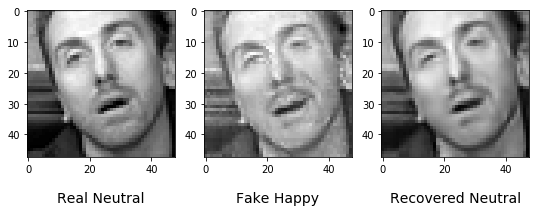

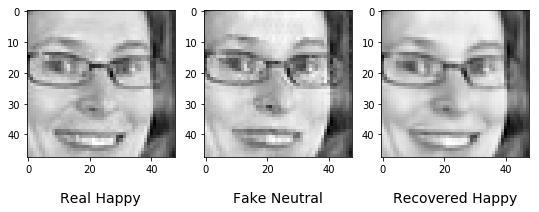

loss_G: 2.5093300342559814, loss_G_GAN: 1.9661155939102173, loss_G_cycle: 0.5432144403457642, loss_D: 0.0009961776668205857
SAVED

------------------------  epoch 191 --------------------------


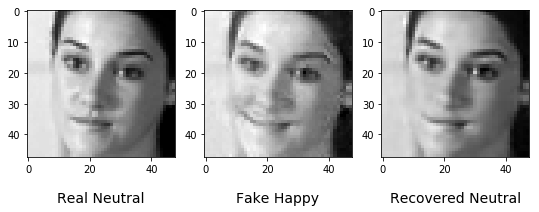

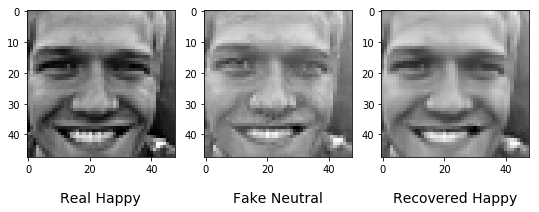

loss_G: 2.403876304626465, loss_G_GAN: 1.9292162656784058, loss_G_cycle: 0.4746600091457367, loss_D: 0.007150811608880758
SAVED

------------------------  epoch 192 --------------------------


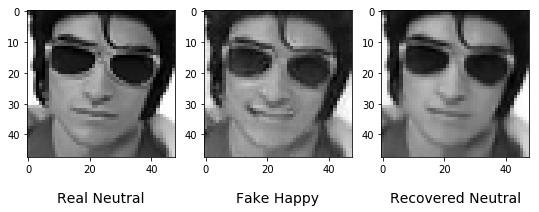

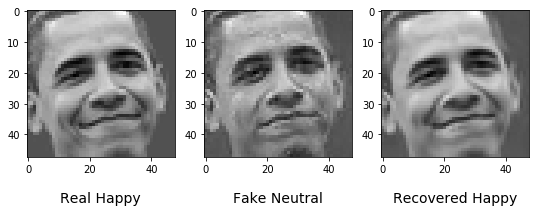

loss_G: 2.39607834815979, loss_G_GAN: 2.0, loss_G_cycle: 0.39607852697372437, loss_D: 0.003989923745393753
SAVED

------------------------  epoch 193 --------------------------


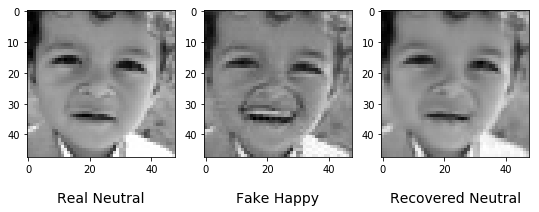

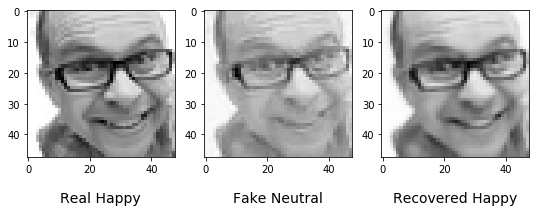

loss_G: 2.8011162281036377, loss_G_GAN: 2.0, loss_G_cycle: 0.8011163473129272, loss_D: 0.007050246000289917
SAVED

------------------------  epoch 194 --------------------------


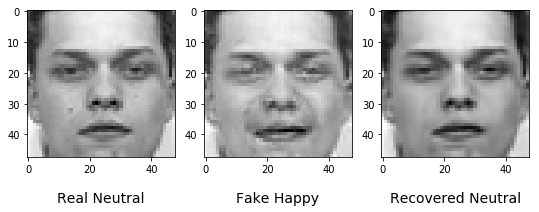

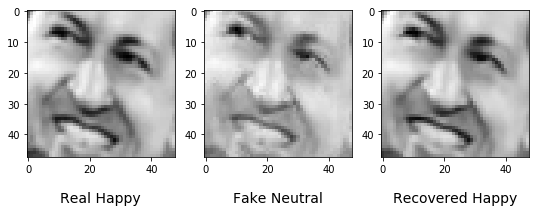

loss_G: 2.388266086578369, loss_G_GAN: 2.0, loss_G_cycle: 0.3882659077644348, loss_D: 0.002408914966508746
SAVED

------------------------  epoch 195 --------------------------


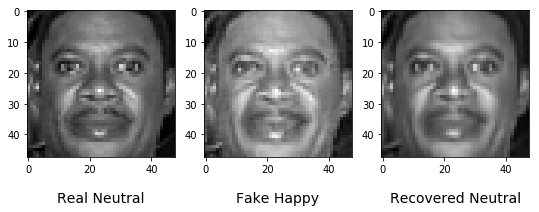

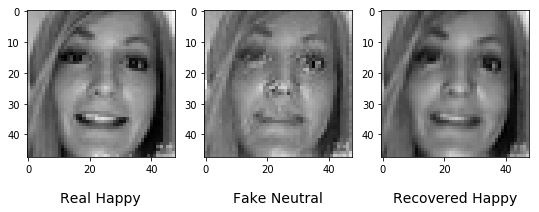

loss_G: 2.5011863708496094, loss_G_GAN: 2.0, loss_G_cycle: 0.501186192035675, loss_D: 0.004555549472570419
SAVED

------------------------  epoch 196 --------------------------


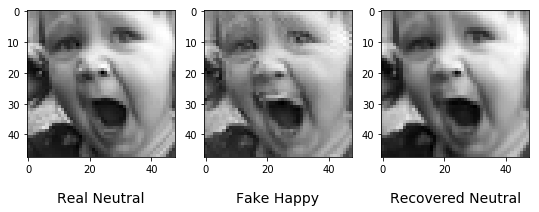

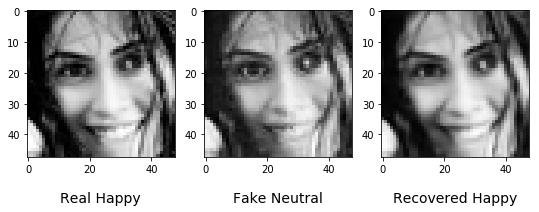

loss_G: 2.4725282192230225, loss_G_GAN: 1.975522756576538, loss_G_cycle: 0.4970054030418396, loss_D: 0.0036668451502919197
SAVED

------------------------  epoch 197 --------------------------


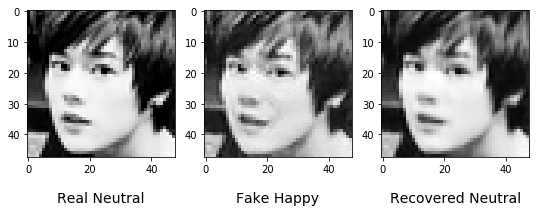

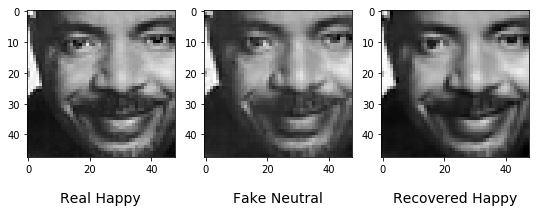

loss_G: 2.3164901733398438, loss_G_GAN: 1.900456428527832, loss_G_cycle: 0.41603386402130127, loss_D: 0.006058120634406805
SAVED

------------------------  epoch 198 --------------------------


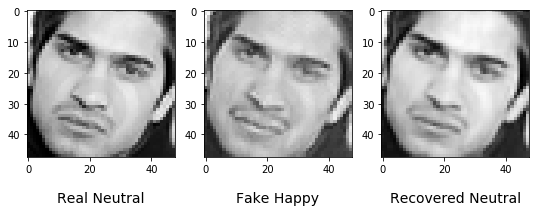

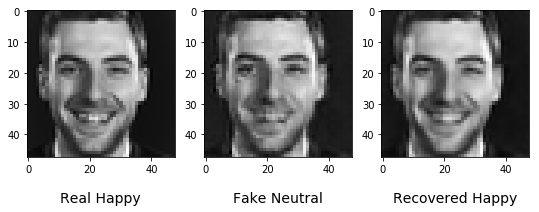

loss_G: 2.4860706329345703, loss_G_GAN: 2.0, loss_G_cycle: 0.4860706329345703, loss_D: 0.0012730825692415237
SAVED

------------------------  epoch 199 --------------------------


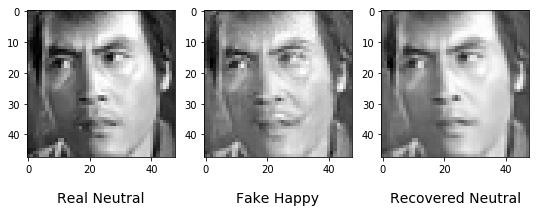

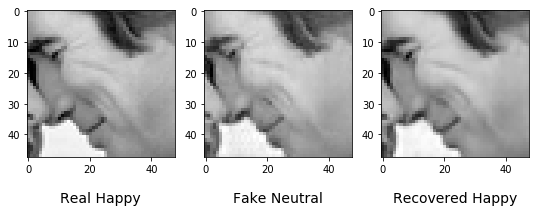

loss_G: 2.321415424346924, loss_G_GAN: 1.9662156105041504, loss_G_cycle: 0.3551996350288391, loss_D: 0.006878343410789967
SAVED

------------------------  epoch 200 --------------------------


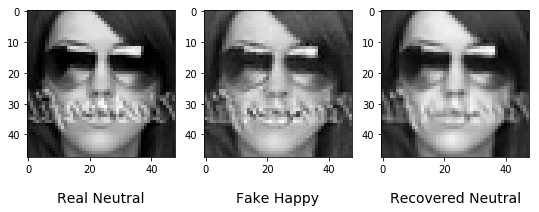

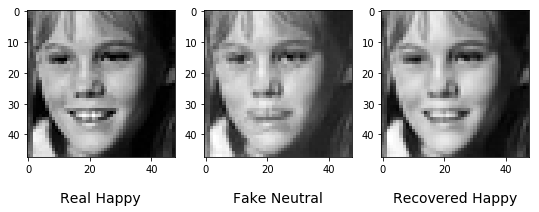

loss_G: 2.39731764793396, loss_G_GAN: 2.0, loss_G_cycle: 0.3973175287246704, loss_D: 0.005585691891610622
SAVED

------------------------  epoch 201 --------------------------


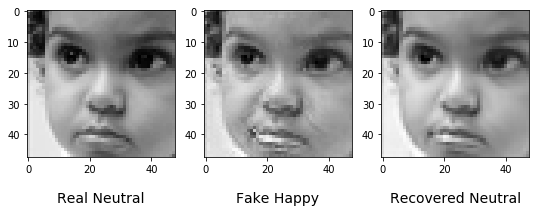

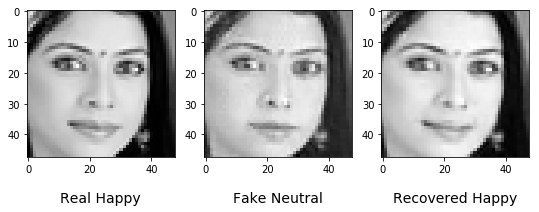

loss_G: 2.3672289848327637, loss_G_GAN: 2.0, loss_G_cycle: 0.36722898483276367, loss_D: 0.0015356468502432108
SAVED

------------------------  epoch 202 --------------------------


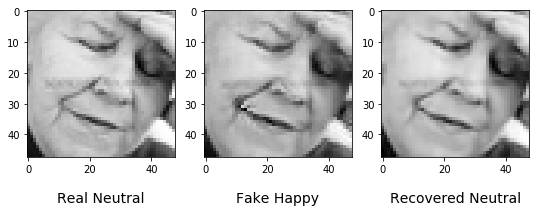

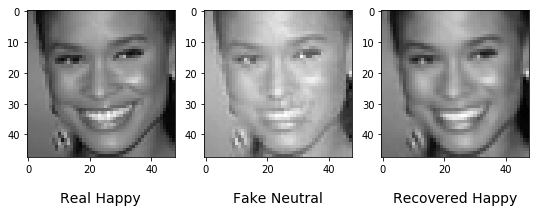

loss_G: 2.3472421169281006, loss_G_GAN: 2.0, loss_G_cycle: 0.3472422957420349, loss_D: 0.003445153357461095
SAVED

------------------------  epoch 203 --------------------------


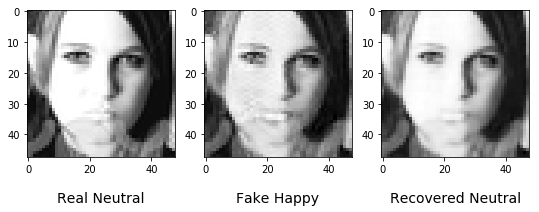

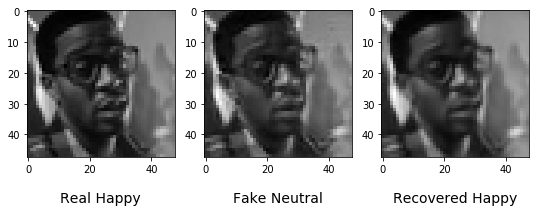

loss_G: 2.523989200592041, loss_G_GAN: 2.0, loss_G_cycle: 0.523989200592041, loss_D: 0.003985204268246889
SAVED

------------------------  epoch 204 --------------------------


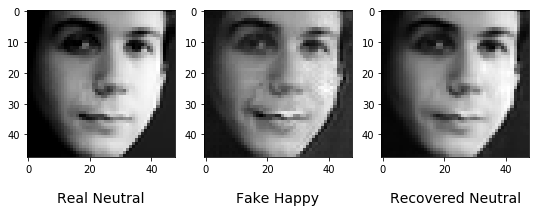

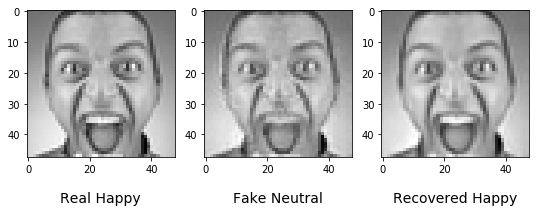

loss_G: 2.425947666168213, loss_G_GAN: 2.0, loss_G_cycle: 0.42594781517982483, loss_D: 0.0058728670701384544
SAVED

------------------------  epoch 205 --------------------------


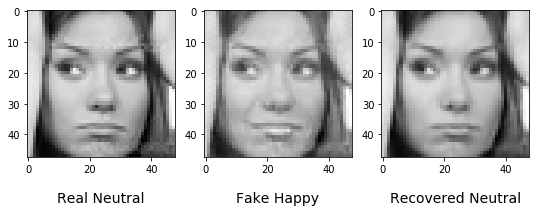

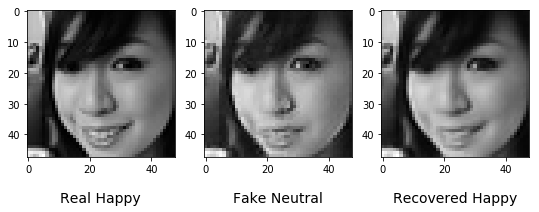

loss_G: 2.507797956466675, loss_G_GAN: 2.0, loss_G_cycle: 0.5077978372573853, loss_D: 0.00253656436689198
SAVED

------------------------  epoch 206 --------------------------


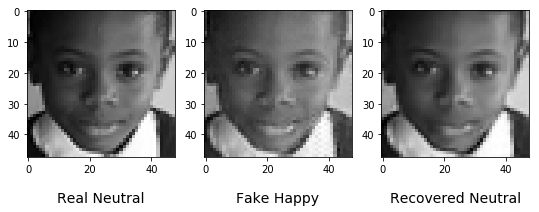

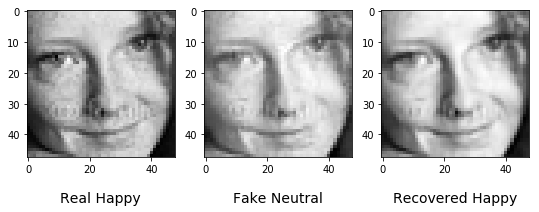

loss_G: 2.3511319160461426, loss_G_GAN: 2.0, loss_G_cycle: 0.3511320650577545, loss_D: 0.0034175668843090534
SAVED

------------------------  epoch 207 --------------------------


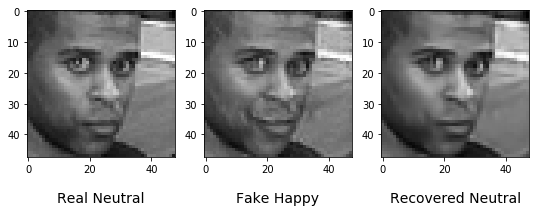

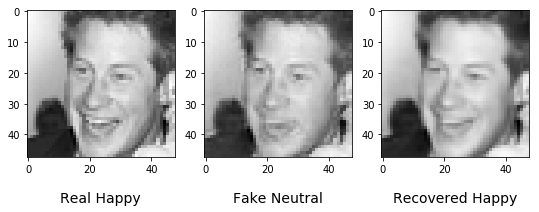

loss_G: 2.387863874435425, loss_G_GAN: 2.0, loss_G_cycle: 0.38786396384239197, loss_D: 0.003036300651729107Buffered data was truncated after reaching the output size limit.

In [0]:
netG_A2B = Generator().type(dtype)
netG_B2A = Generator().type(dtype)
netD_A = Discriminator().type(dtype)
netD_B = Discriminator().type(dtype)
print("\nSTARTED TRAINING\n")
train_runner(netG_A2B, netG_B2A, netD_A, netD_B,
             load=True, emotion_A='Neutral', emotion_B='Happy',
             n_epochs=1, image_pool_size=64, batchSize=4)